# First steps with sangria dataset

## Software requirements

- git clone https://gitlab.in2p3.fr/LISA/LDC
- pip install requirements.txt
- python setup.py install

## Downloading the sangria dataset

- https://lisa-ldc.lal.in2p3.fr/
- https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_sangria_v1.h5


In [3]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import xarray as xr
from astropy import units as u

import ldc.io.hdf5 as hdfio
from ldc.lisa.noise import get_noise_model
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.common.series import TimeSeries, FrequencySeries, window
import ldc.waveform.fastGB as fastGB
from ldc.common.tools import compute_tdi_snr
from ldc.waveform.waveform import HpHc

In [5]:
DATAPATH = "/home/stefan/LDC/Sangria/data"
sangria_fn = DATAPATH+"/LDC2_sangria_training_v1.h5"
tdi_ts, tdi_descr = hdfio.load_array(sangria_fn, name="obs/tdi")
dt = int(1/(tdi_descr["sampling_frequency"]))

# Build timeseries and frequencyseries object for X,Y,Z
tdi_ts = xr.Dataset(dict([(k,TimeSeries(tdi_ts[k], dt=dt)) for k in ["X", "Y", "Z"]]))
tdi_fs = xr.Dataset(dict([(k,tdi_ts[k].ts.fft(win=window)) for k in ["X", "Y", "Z"]]))

## Looking at PSDs

In [14]:
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
Npsd = Nmodel.psd()
plt.figure(figsize=(8,6))
f, psdX =  scipy.signal.welch(tdi_ts["X"], fs=1.0/dt, window='hanning', nperseg=256*256)
plt.loglog(f, np.sqrt(psdX), label="TDI X")
plt.loglog(Nmodel.freq, np.sqrt(Npsd), label=noise_model, alpha=2)
plt.legend()
plt.xlabel("freq [Hz]")
plt.ylabel("PSD")
plt.axis([1e-5, None, 4e-22, 2e-19])
print('s')
plt.show()
print('s')

s


ValueError: RGBA values should be within 0-1 range

## Verification binary subtraction

Text(0.5, 0, 'freq [Hz]')

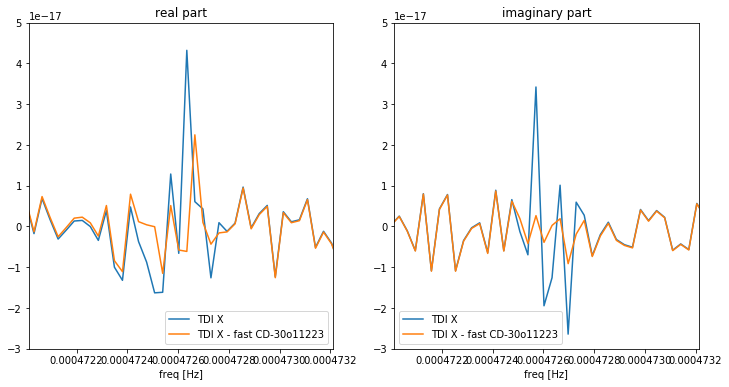

In [15]:
vgb, units = hdfio.load_array(sangria_fn, name="sky/vgb/cat")
GB = fastGB.FastGB(delta_t=dt, T=float(tdi_ts["X"].t[-1])) # in seconds
pGB = dict(zip(vgb.dtype.names, vgb[8])) # we take the source #8
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("real part")
plt.plot(tdi_fs["X"].f, tdi_fs["X"].real, label="TDI X")
plt.plot(Xs.f, (tdi_fs["X"][Xs.kmin:Xs.kmin+len(Xs)]-Xs.values).real, label="TDI X - fast "+pGB["Name"])
plt.axis([pGB["Frequency"]-6e-7, pGB["Frequency"]+6e-7, -3e-17, 5e-17])
plt.legend(loc="lower right")
plt.xlabel("freq [Hz]")
plt.subplot(122)
plt.title("imaginary part")
plt.plot(tdi_fs["X"].f, tdi_fs["X"].imag, label="TDI X")
plt.plot(Xs.f, (tdi_fs["X"].isel(f=slice(Xs.kmin, Xs.kmin+len(Xs)))-Xs.values).imag, label="TDI X - fast "+pGB["Name"])
plt.axis([pGB["Frequency"]-6e-7, pGB["Frequency"]+6e-7, -3e-17, 5e-17])
plt.legend(loc="lower left")
plt.xlabel("freq [Hz]")

## Computing the SNR of verification binaries

In [17]:
vgb, units = hdfio.load_array(sangria_fn, name="sky/vgb/cat")
GB = fastGB.FastGB(delta_t=dt, T=float(tdi_ts["X"].t[-1])) # in seconds
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
SNR2 = np.zeros((len(vgb), 2)) # snr square
for j,s in enumerate(vgb):
    pGB = dict(zip(vgb.dtype.names, s))
    Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')
    fmin, fmax = float(Xs.f[0]) , float(Xs.f[-1]+Xs.attrs['df'])
    source = dict({"X":Xs, "Y":Ys, "Z":Zs})
    SNR2[j,1] = compute_tdi_snr(source, Nmodel, data=tdi_fs, fmin=fmin, fmax=fmax)["tot2"]
    SNR2[j,0] = compute_tdi_snr(source, Nmodel)["tot2"] 

In [18]:
import pandas as pd
data = np.array([vgb["Name"], vgb["Frequency"], SNR2[:,0], SNR2[:,1]]).T
pd.DataFrame(data, columns=["Name", "f0", "fastGB", "TDI"])

,Name,f0,fastGB,TDI
0,V407_Vul,0.0035125,294.6125537427847,378.64301048641505
1,SDSS_J135154.46,0.002119003220884896,665.3475097718492,646.768265200897
2,AM_CVn,0.00194414,9477.076579748393,9694.88348413445
3,SDSS_J190817.07+394036.4,0.0018421295017039697,907.4601079207469,244.88667043581208
4,ZTF_J153932.16+502738.8,0.004821699107149872,3933.088300803515,4428.477705829545
5,CR_Boo,0.00135962,6243.716230026795,6034.707189869316
6,SDSS_J093506.92+441107.0,0.00166667,238.67892625581305,208.91939092441598
7,PTF1_J191905.19+481506.2,0.0014843952944669167,35.84378453300472,-29.51278710510161
8,CD-30o11223,0.000472612,2074.2237259401954,1865.8910840606766
9,SDSS_J092345.59+302805.0,0.0005149728351829441,30.902479699570776,38.801075299515084


## MBHBs

This part should be updated with a MBHB fast approximation provided by the ldc toolbox

In [27]:
def semi_fast_tdi(config, pMBHB, t_max, dt):
    hphc = HpHc.type("MBHB-%d"%s_index, "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    orbits = Orbits.type(config)
    P = ProjectedStrain(orbits)    
    yArm = P.arm_response(0, t_max, dt, [hphc], tt_order=1)
    X = P.compute_tdi_x(np.arange(0, t_max, dt))
    return TimeSeries(X, dt=dt)

default_units = {'EclipticLatitude':'rad','EclipticLongitude':'rad',
         'PolarAngleOfSpin1':'rad','PolarAngleOfSpin2':'rad',
         'Spin1': '1','Spin2':'1',
         'Mass1':'Msun','Mass2':'Msun',
         'CoalescenceTime': 's','PhaseAtCoalescence':'rad',
         'InitialPolarAngleL':'rad','InitialAzimuthalAngleL':'rad',
         'Cadence': 's','Redshift': '1','Distance': 'Gpc',
         'ObservationDuration':'s'}

mbhb, units = hdfio.load_array(sangria_fn, name="sky/mbhb/cat")
print(units)
if not units:
    units = default_units
config = hdfio.load_config(sangria_fn, name="obs/config")
print(config)
s_index = 0
pMBHB = dict(zip(mbhb.dtype.names, mbhb[s_index]))
units = default_units
for k,v in pMBHB.items():
    print(k)
    pMBHB[k] *= u.Unit(units[k])

t_max = float(tdi_ts["X"].t[-1]+tdi_ts["X"].attrs["dt"])
Xs = semi_fast_tdi(config, pMBHB, t_max, dt)

plt.figure(figsize=(12,6))
plt.plot(tdi_ts["X"].t, tdi_ts["X"], label="TDI X")
plt.plot(Xs.t, (tdi_ts["X"]-Xs), label="TDI X - fast %d"%s_index)
plt.axis([pMBHB["CoalescenceTime"]-600, pMBHB["CoalescenceTime"]+600, None, None])
plt.legend(loc="lower right")
plt.xlabel("time [s]")

{'CoalescenceTime': 's', 'Distance': 'Mpc', 'EclipticLatitude': 'rad', 'EclipticLongitude': 'rad', 'Inclination': 'rad', 'InitialAzimuthalAngleL': 'rad', 'InitialPolarAngleL': 'rad', 'Mass1': 'Msun', 'Mass2': 'Msun', 'PhaseAtCoalescence': 'rad', 'PolarAngleOfSpin1': 'rad', 'PolarAngleOfSpin2': 'rad', 'Polarization': 'rad', 'Redshift': '1', 'Spin1': '1', 'Spin2': '1'}
{'accnoise': 2.4e-15, 'dirname': 'run2', 'dt': <Quantity 3. s>, 'initial_position': <Quantity 0. rad>, 'initial_rotation': <Quantity 0. rad>, 'interp_order': 3, 'ldc_liborbits': '/codes/LDC/ldc/lisa/orbits', 'nbatch': 1, 'nominal_arm_length': <Quantity 2.5e+09 m>, 'opticalnoise': 5e-12, 'orbit_type': 'analytic', 'readoutnoise': 6.35e-12, 't_max': <Quantity 31536000. s>, 't_min': <Quantity 0. s>, 'travel_time_order': 1}
EclipticLatitude
EclipticLongitude
PolarAngleOfSpin1
PolarAngleOfSpin2
Spin1
Spin2
Mass1
Mass2
CoalescenceTime
PhaseAtCoalescence
InitialPolarAngleL
InitialAzimuthalAngleL
Redshift
Distance
ObservationDurati

ValueError: 

In [20]:
config["t_max"].unit

Unit("s")

In [28]:
def mldc_fast_tdi(pMBHB, t_max, dt):
    from GenerateFD_SignalTDIs import ComputeMBHBXYZ_FD
    from LISAhdf5 import ParsUnits
    hphc = HpHc.type("MBHB-%d"%s_index, "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    pMBHB["Cadence"] = dt
    pMBHB["ObservationDuration"] = t_max/2
    pu = ParsUnits(pars_i=pMBHB, units_i=hphc.info())
    fr, Xs, Ys, Zs = ComputeMBHBXYZ_FD(pu)
    return (FrequencySeries(Xs, df=1/t_max), 
            FrequencySeries(Ys, df=1/t_max),
            FrequencySeries(Zs, df=1/t_max))

mbhb = hdfio.load_array(sangria_fn, name="sky/mbhb/cat", full_output=False)
config = hdfio.load_config(sangria_fn, name="obs/config")
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
SNR2 = np.zeros((len(mbhb), 2)) 
for j,s in enumerate(mbhb):
    pMBHB = dict(zip(mbhb.dtype.names, s))
    Xs,Ys,Zs = mldc_fast_tdi(pMBHB, t_max, dt)
    source = dict({"X":Xs, "Y":Ys, "Z":Zs})
    SNR2[j,1] = compute_tdi_snr(source, Nmodel, data=tdi_fs)["tot2"]
    SNR2[j,0] = compute_tdi_snr(source, Nmodel)["tot2"]

In [29]:
import pandas as pd
data = np.array([range(len(mbhb)), mbhb["CoalescenceTime"], SNR2[:,0], SNR2[:,1]]).T
pd.DataFrame(data, columns=["index", "tc", "fast", "TDI"])

,index,tc,fast,TDI
0,0.0,1.152694e+07,1.251172e+07,1.062719e+06
1,1.0,1.125857e+07,4.515517e+06,1.108071e+06
2,2.0,1.653219e+07,7.369434e+05,5.720497e+05
3,3.0,2.951609e+07,3.341613e+05,2.554444e+05
4,4.0,1.860576e+07,1.229539e+06,1.052163e+06
5,5.0,1.116784e+07,2.105535e+05,1.171869e+05
6,6.0,8.746488e+06,8.776491e+04,-2.281454e+04
7,7.0,1.724516e+07,7.718141e+05,-3.280103e+05
8,8.0,2.440876e+07,9.560500e+05,-4.296052e+05
9,9.0,2.042622e+07,5.168639e+06,-2.678803e+06
